In [1]:
from torch.utils.data import DataLoader
from dataset import MNISTDataset
from model_trainer import deep_feature_reweighting, train
from models import SimpleModel
from spurious_features import Position, spurious_square, SpuriousFeature
import torch

from experiments import run_experiments

In [3]:
spurious_features = {
    9: lambda img: spurious_square(img, pos=Position.LEFT_TOP, size=5),
    7: lambda img: spurious_square(img, pos=Position.RIGHT_BOTTOM, size=5),
}

probabilities = {9: 0.95, 7: 0.95}

opposite_spurious_features = {
    9: lambda img: spurious_square(img, pos=Position.RIGHT_BOTTOM, size=5),
    7: lambda img: spurious_square(img, pos=Position.LEFT_TOP, size=5),
}

opposite_probabilities = {9: 0.95, 7: 0.95}

config = {"batch_size": [32, 64], "latent_size": [128, 512]}

run_experiments(
    experiment_title="Experiment 1",
    labels=[7, 9],
    spurious_features=spurious_features,
    spurious_probabilities=probabilities,
    opposite_spurious_features=opposite_spurious_features,
    opposite_spurious_probabilities=opposite_probabilities,
    experiment_config=config,
)

KeyboardInterrupt: 

In [2]:
only_spurious = MNISTDataset(
    train=True,
    labels=[9, 7],
    spurious_features={
        9: lambda img: spurious_square(
            img, pos=Position.LEFT_TOP, size=5, only_spurious=True
        ),
        7: lambda img: spurious_square(
            img, pos=Position.RIGHT_BOTTOM, size=5, only_spurious=True
        ),
    },
    probabilities={9: 1, 7: 1},
)

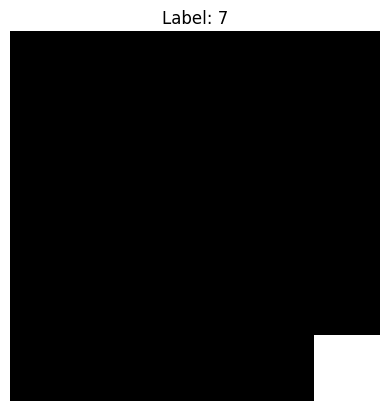

In [7]:
only_spurious.view_item(1)

In [2]:
top_left_square = SpuriousFeature(
    spurious_square, "Spurious Square Left Top", pos=Position.LEFT_TOP, size=5
)
bottom_right_square = SpuriousFeature(
    spurious_square, "Spurious Square Bottom Right", pos=Position.RIGHT_BOTTOM, size=5
)

train_dataset = MNISTDataset(
    train=True,
    labels=[9, 7],
    main_spurious_features={
        9: top_left_square,
        7: bottom_right_square,
    },
    minority_spurious_features={9: bottom_right_square, 7: top_left_square},
    probabilities={9: 0.95, 7: 0.95},
)

same_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
    main_spurious_features={
        9: top_left_square,
        7: bottom_right_square,
    },
    minority_spurious_features={9: bottom_right_square, 7: top_left_square},
    probabilities={9: 0.95, 7: 0.95},
)

opposite_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
    main_spurious_features={
        9: bottom_right_square,
        7: top_left_square,
    },
    minority_spurious_features={9: top_left_square, 7: bottom_right_square},
    probabilities={9: 0.95, 7: 0.95},
)

non_spurious_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
)

# TODO
# only spurious dataset = MNISTDataset()

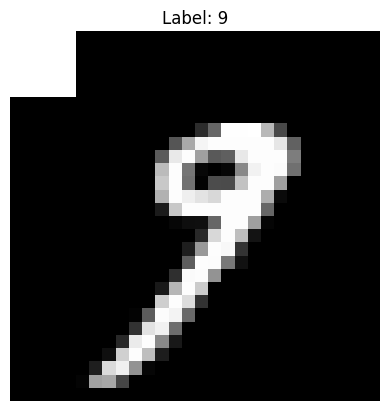

In [3]:
train_dataset.view_item(5)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataloaders = {
    "Unbiased": DataLoader(
        non_spurious_validation_dataset, batch_size=64, shuffle=False
    ),
    "Spurious": DataLoader(same_validation_dataset, batch_size=64, shuffle=False),
    "Opposite": DataLoader(opposite_validation_dataset, batch_size=64, shuffle=False),
}

In [5]:
model = SimpleModel(num_classes=2)

model_path, tensorboard_path = train(
    model=model,
    validation_loaders=validation_dataloaders,
    train_loader=train_loader,
    num_epochs=15,
    optimizer_type=torch.optim.Adam,
    lr=0.001,
    weight_decay=1e-3,
    use_early_stopping=True,
    patience=2,
)

Epochs:  47%|████▋     | 7/15 [00:48<00:55,  6.97s/it, Train Loss=0.0091, Valid Loss Unbiased=0.0164, Train Accuracy=99.71%, Valid Accuracy Unbiased=0.995, Valid Accuracy Spurious=0.999, Valid Accuracy Opposite=0.977, Valid Worst Group Accuracy Unbiased=0.994, Valid Worst Group Accuracy Spurious=0.98, Valid Worst Group Accuracy Opposite=0.972] 

Early Stopping triggered


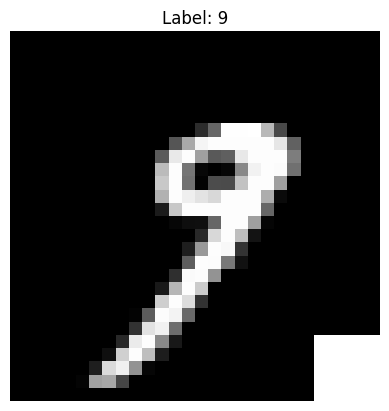

In [7]:
dfr_train_set = MNISTDataset(
    train=True,
    labels=[9, 7],
    main_spurious_features={9: top_left_square, 7: bottom_right_square},
    minority_spurious_features={9: bottom_right_square, 7: top_left_square},
    probabilities={7: 0.5, 9: 0.5},
)
dfr_loader = DataLoader(dfr_train_set, batch_size=64, shuffle=True)
dfr_train_set.view_item(5)

In [8]:
model_path, tensorboard_path = deep_feature_reweighting(
    path_to_model=model_path,
    path_to_tensorboard_run=tensorboard_path,
    model=SimpleModel(num_classes=2),
    num_epochs=50,
    validation_loaders=validation_dataloaders,
    train_loader=dfr_loader,
    optimizer_type=torch.optim.Adam,
    lr=0.001,
    weight_decay=1e-3,
)

Reweighting Epochs:  36%|███▌      | 18/50 [01:18<02:19,  4.35s/it, Train Loss=0.0233, Valid Loss Unbiased=0.0150, Train Accuracy=99.33%, Valid Accuracy Unbiased=0.995, Valid Accuracy Spurious=0.999, Valid Accuracy Opposite=0.988, Valid Worst Group Accuracy Unbiased=0.994, Valid Worst Group Accuracy Spurious=0.98, Valid Worst Group Accuracy Opposite=0.987]

Early stopping triggered


In [9]:
tensorboard_path

'runs/10_12_2024_1244'